In [156]:
import os
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Import the orders data

### (check mock_orders_data code to generate your own test data)

In [157]:
def get_current_directory():
    return os.getcwd()

dir = get_current_directory()

In [158]:
df_orders = pd.read_csv(dir + '/orders.csv', sep=';')

In [159]:
df_orders.head()

,order_date,customer_id,user_segment,product_id,product_segment,order_year,order_value_eur
0,2021-12-16,CUST-9198,large,PROD-263,product-segment-1,2021,833.48
1,2021-12-14,CUST-5321,large,PROD-769,product-segment-1,2021,889.39
2,2021-07-11,CUST-4352,large,PROD-346,product-segment-3,2021,689.92
3,2021-04-05,CUST-1908,large,PROD-345,product-segment-1,2021,529.83
4,2021-03-16,CUST-3863,medium,PROD-318,product-segment-2,2021,288.24


In [160]:
# Example of how to pass the variables for product_segments, user_segments, and years:
product_segments = df_orders['product_segment'].unique()
user_segments = df_orders['user_segment'].unique()
years = df_orders['order_year'].unique()

# Now Let's Generate The Insights for our retourning customers

## Group by 'customer_id', 'user_segment', 'product_segment', 'order_year' and then choose a target variable for your customer analysis 

In [161]:
# Step 1: Group the orders dataframe by customer_id, user_segment, product_segment, and order_year, and calculate the count of orders and sum of order_value_eur
grouped_df = df_orders.groupby(['customer_id', 'user_segment', 'product_segment', 'order_year']).agg(
    order_count=('order_date', 'count'),
    total_spending=('order_value_eur', 'sum')
).reset_index()


In [162]:
grouped_df.head()

,customer_id,user_segment,product_segment,order_year,order_count,total_spending
0,CUST-0001,large,product-segment-2,2023,1,735.96
1,CUST-0001,small,product-segment-1,2022,1,59.35
2,CUST-0001,small,product-segment-2,2021,1,122.66
3,CUST-0002,large,product-segment-3,2021,1,982.20
4,CUST-0002,large,product-segment-3,2023,1,992.84


In [163]:

# Step 2: Create a function that generates a series of dataframes for each unique user_segment and year
def get_dataframes_for_segment_year(df, target='total_spending'):
    user_segments = df['user_segment'].unique()
    years = df['order_year'].unique()
    segment_year_dataframes = {}
    
    for segment in user_segments:
        for year in years:
            # Filter the dataframe for specific user segment and year
            filtered_df = df[(df['user_segment'] == segment) & (df['order_year'] == year)]
            segment_year_dataframes[(segment, year)] = filtered_df
    
    return segment_year_dataframes

In [164]:

# Step 3: Define a function to transform the dataframe
def transform_df(df, target):
    # Pivot the dataframe, keeping product_segment as columns
    pivot_df = df.pivot_table(index='customer_id', columns='product_segment', values=target, aggfunc='sum', fill_value=0)
    
    # Reset the index to get customer_id as a column
    pivot_df = pivot_df.reset_index()
    
    # Calculate the total value as the sum of the product segments' target values
    pivot_df['total_value'] = pivot_df.sum(axis=1, numeric_only=True)
    
    #rename index
    pivot_df = pivot_df.rename_axis(None, axis=1)
    
    return pivot_df



In [165]:
# Step 4: Define the main function that applies the transformation to all segment-year dataframes
def process_segment_year_dataframes(df, target):
    # Get a dictionary of dataframes for each segment-year combination
    segment_year_dfs = get_dataframes_for_segment_year(df, target)
    
    # Transform each dataframe
    transformed_dfs = {}
    for (segment, year), segment_df in segment_year_dfs.items():
        transformed_dfs[(segment, year)] = transform_df(segment_df, target)
    
    return transformed_dfs




### Define the target variable

In [166]:
target='total_spending'

In [167]:
# Applying the functions
transformed_dataframes = process_segment_year_dataframes(grouped_df, target)

In [168]:
transformed_dataframes[('small', 2021)].head()

,customer_id,product-segment-1,product-segment-2,product-segment-3,total_value
0,CUST-0001,0.00,122.66,0.00,122.66
1,CUST-0004,0.00,134.89,0.00,134.89
2,CUST-0009,134.35,0.00,0.00,134.35
3,CUST-0015,0.00,0.00,84.05,84.05
4,CUST-0019,60.36,0.00,0.00,60.36


## Now calculate the difference between one year to the following of the previously selected target variable 

In [169]:
def calculate_differences_between_years(transformed_dataframes):
    # Get the years that are available in the transformed_dataframes
    years = sorted(set(year for _, year in transformed_dataframes.keys()))
    
    returning_customers_dfs = {}
    
    # Iterate through consecutive years
    for i in range(len(years) - 1):
        previous_year = years[i]
        following_year = years[i + 1]
        
        # Iterate through user segments
        for segment in transformed_dataframes.keys():
            customer_segment = segment[0]  # Get the customer segment (small, medium, large)
            if (customer_segment, previous_year) in transformed_dataframes and (customer_segment, following_year) in transformed_dataframes:
                df_previous = transformed_dataframes[(customer_segment, previous_year)]
                df_following = transformed_dataframes[(customer_segment, following_year)]
                
                # Merge previous and following year dataframes on customer_id
                merged_df = pd.merge(df_previous, df_following, on='customer_id', how='inner', suffixes=('_previous', '_following'))
                
                # Fill NaNs with 0 where there are missing values for the following year
                merged_df.fillna(0, inplace=True)
                
                # Calculate the differences for each product segment
                product_segments = [col for col in df_previous.columns if col != 'customer_id' and col != 'total_value']
                for segment_col in product_segments:
                    merged_df[f'{segment_col}_diff'] = merged_df[f'{segment_col}_following'] - merged_df[f'{segment_col}_previous']
                
                # Calculate the total difference
                merged_df['total_diff'] = merged_df['total_value_following'] - merged_df['total_value_previous']
                
                # Store the customer segment to use it later for filtering
                merged_df['user_segment'] = customer_segment
                
                # Store the result in a dictionary
                returning_customers_dfs[f'returning_customers_{customer_segment}_{previous_year}_{following_year}'] = merged_df
    
    return returning_customers_dfs


In [170]:
# Applying the function to the transformed_dataframes
returning_customers_dfs = calculate_differences_between_years(transformed_dataframes)

In [171]:
returning_customers_dfs.keys()

dict_keys(['returning_customers_large_2021_2022', 'returning_customers_small_2021_2022', 'returning_customers_medium_2021_2022', 'returning_customers_large_2022_2023', 'returning_customers_small_2022_2023', 'returning_customers_medium_2022_2023', 'returning_customers_large_2023_2024', 'returning_customers_small_2023_2024', 'returning_customers_medium_2023_2024'])

In [172]:
# Display one example of the resulting dataframes for returning customers between 2021 and 2022
returning_customers_dfs['returning_customers_large_2021_2022'].head()

,customer_id,product-segment-1_previous,product-segment-2_previous,product-segment-3_previous,total_value_previous,product-segment-1_following,product-segment-2_following,product-segment-3_following,total_value_following,product-segment-1_diff,product-segment-2_diff,product-segment-3_diff,total_diff,user_segment
0,CUST-0008,0.00,698.58,0.00,698.58,0.0,939.03,742.80,1681.83,0.00,240.45,742.80,983.25,large
1,CUST-0011,0.00,0.00,722.45,722.45,0.0,993.18,0.00,993.18,0.00,993.18,-722.45,270.73,large
2,CUST-0019,937.71,0.00,0.00,937.71,1386.3,0.00,0.00,1386.30,448.59,0.00,0.00,448.59,large
3,CUST-0028,528.81,0.00,0.00,528.81,0.0,0.00,883.06,883.06,-528.81,0.00,883.06,354.25,large
4,CUST-0036,0.00,743.21,0.00,743.21,0.0,0.00,839.75,839.75,0.00,-743.21,839.75,96.54,large


# Save the dataframe for Future Analysis

In [173]:
combined_df = pd.DataFrame()

# Iterate through the dictionary to add the 'customer_segment' and 'year_to_year' columns
for key, df in returning_customers_dfs.items():
    # Extract customer segment and year-to-year info from the key
    customer_segment = key.split('_')[2]  # e.g., 'large', 'small', etc.
    year_to_year = f"{key.split('_')[3]}_{key.split('_')[4]}"  # e.g., '2021_2022'
    
    # Add the new columns to the dataframe
    df['customer_segment'] = customer_segment
    df['year_to_year'] = year_to_year
    
    # Append the dataframe to the combined dataframe
    combined_df = pd.concat([combined_df, df], ignore_index=True)

In [174]:
combined_df.head()

,customer_id,product-segment-1_previous,product-segment-2_previous,product-segment-3_previous,total_value_previous,product-segment-1_following,product-segment-2_following,product-segment-3_following,total_value_following,product-segment-1_diff,product-segment-2_diff,product-segment-3_diff,total_diff,user_segment,customer_segment,year_to_year
0,CUST-0008,0.00,698.58,0.00,698.58,0.0,939.03,742.80,1681.83,0.00,240.45,742.80,983.25,large,large,2021_2022
1,CUST-0011,0.00,0.00,722.45,722.45,0.0,993.18,0.00,993.18,0.00,993.18,-722.45,270.73,large,large,2021_2022
2,CUST-0019,937.71,0.00,0.00,937.71,1386.3,0.00,0.00,1386.30,448.59,0.00,0.00,448.59,large,large,2021_2022
3,CUST-0028,528.81,0.00,0.00,528.81,0.0,0.00,883.06,883.06,-528.81,0.00,883.06,354.25,large,large,2021_2022
4,CUST-0036,0.00,743.21,0.00,743.21,0.0,0.00,839.75,839.75,0.00,-743.21,839.75,96.54,large,large,2021_2022


In [175]:
base_columns = ['customer_id', 'customer_segment', 'year_to_year']

# Dynamically build the product segment columns (e.g., product-segment-1_previous, product-segment-1_following, product-segment-1_diff)
dynamic_columns = []
for segment in product_segments:
    dynamic_columns.append(f'{segment}_previous')
    dynamic_columns.append(f'{segment}_following')
    dynamic_columns.append(f'{segment}_diff')

# Add total columns to the end
total_columns = ['total_value_previous', 'total_value_following', 'total_diff']

# Final order of columns
ordered_columns = base_columns + dynamic_columns + total_columns

# Now, assuming combined_df contains the data, reorder it based on this dynamic column list
combined_df = combined_df[ordered_columns]

In [176]:
combined_df.head()

,customer_id,customer_segment,year_to_year,product-segment-1_previous,product-segment-1_following,product-segment-1_diff,product-segment-3_previous,product-segment-3_following,product-segment-3_diff,product-segment-2_previous,product-segment-2_following,product-segment-2_diff,total_value_previous,total_value_following,total_diff
0,CUST-0008,large,2021_2022,0.00,0.0,0.00,0.00,742.80,742.80,698.58,939.03,240.45,698.58,1681.83,983.25
1,CUST-0011,large,2021_2022,0.00,0.0,0.00,722.45,0.00,-722.45,0.00,993.18,993.18,722.45,993.18,270.73
2,CUST-0019,large,2021_2022,937.71,1386.3,448.59,0.00,0.00,0.00,0.00,0.00,0.00,937.71,1386.30,448.59
3,CUST-0028,large,2021_2022,528.81,0.0,-528.81,0.00,883.06,883.06,0.00,0.00,0.00,528.81,883.06,354.25
4,CUST-0036,large,2021_2022,0.00,0.0,0.00,0.00,839.75,839.75,743.21,0.00,-743.21,743.21,839.75,96.54


In [177]:
combined_df.to_csv(dir + '/combined_df.csv', index=False)

# Display the performances across across different customer and product segments - Difference in Target Valieble

In [178]:
def plot_heatmaps_for_year_pairs_diff(returning_customers_dfs, product_segments, user_segments, years, target_variable):
    # Iterate over consecutive years (previous and following)
    for i in range(len(years) - 1):
        previous_year = years[i]
        following_year = years[i + 1]

        # Initialize containers for the total calculations (for title, not the matrix)
        total_diff = 0

        # Create an empty DataFrame for the heatmap with product segments as rows and user segments as columns
        heatmap_data = pd.DataFrame(index=product_segments, columns=user_segments)

        # Loop through customer segments
        for segment in user_segments:
            key = f'returning_customers_{segment}_{previous_year}_{following_year}'
            if key not in returning_customers_dfs:
                continue  # Skip if this year pair doesn't exist for the current segment
            
            segment_df = returning_customers_dfs[key]

            # Calculate total diff for each customer segment (for title, not matrix)
            total_diff_segment = segment_df['total_diff'].sum()
            total_diff += total_diff_segment

            # Populate the heatmap with the actual difference in spending for each product segment
            for product in product_segments:
                product_diff_sum = segment_df[f'{product}_diff'].sum()  # Use the raw diff values here
                heatmap_data.at[product, segment] = product_diff_sum  # Add the raw difference value to the heatmap

        # Plot the heatmap with raw difference values
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap_data.astype(float), annot=True, cmap='coolwarm', cbar=True, fmt='.2f')

        # Add a title with total difference (raw values)
        plt.title(f'Distribution of Raw Differences between {previous_year} and {following_year} in {target_variable}\n'
                  f'Total Difference: {int(total_diff)}')
        plt.ylabel('Product Segments')
        plt.xlabel('Customer Segments')

        # Display the heatmap
        plt.tight_layout()
        plt.show()




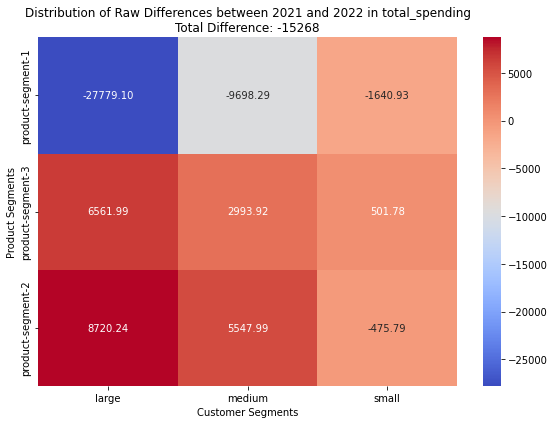

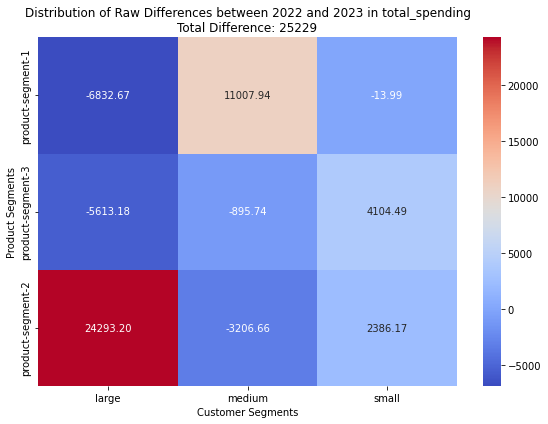

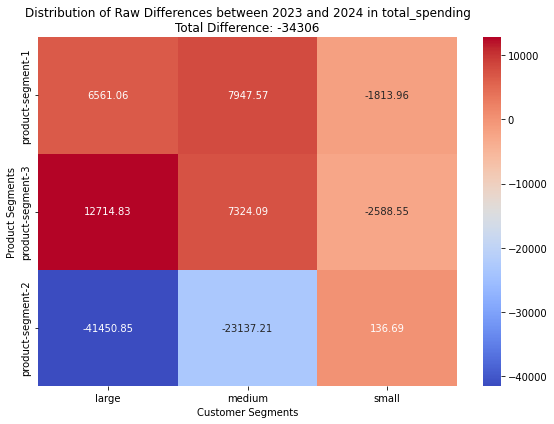

In [179]:
# Usage example for raw differences
plot_heatmaps_for_year_pairs_diff(returning_customers_dfs, product_segments, user_segments, years, target)

# Diplay The difference In percentage

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmaps_for_year_pairs_perc(returning_customers_dfs, product_segments, user_segments, years, target_variable):
    # Iterate over consecutive years (previous and following)
    for i in range(len(years) - 1):
        previous_year = years[i]
        following_year = years[i + 1]

        # Initialize containers for the total calculations (outside heatmap)
        total_previous = 0
        total_diff = 0

        # Create an empty DataFrame for the heatmap with product segments as rows and user segments as columns
        heatmap_data = pd.DataFrame(index=product_segments, columns=user_segments)

        # Loop through customer segments
        for segment in user_segments:
            key = f'returning_customers_{segment}_{previous_year}_{following_year}'
            if key not in returning_customers_dfs:
                continue  # Skip if this year pair doesn't exist for the current segment
            
            segment_df = returning_customers_dfs[key]

            # Calculate total previous and total diff for each customer segment (for title, not matrix)
            total_previous_segment = segment_df['total_value_previous'].sum()
            total_diff_segment = segment_df['total_diff'].sum()

            total_previous += total_previous_segment
            total_diff += total_diff_segment

            # Calculate the percentage differences for each product segment
            for product in product_segments:
                product_diff_sum = segment_df[f'{product}_diff'].sum()
                percentage_diff = (product_diff_sum / total_diff_segment) * 100 if total_diff_segment != 0 else 0
                heatmap_data.at[product, segment] = percentage_diff  # Only add product-specific differences

        # Calculate percentage diff for the title (do not include totals in the matrix)
        overall_percentage_diff = (total_diff / total_previous) * 100 if total_previous != 0 else 0

        # Plot the heatmap (with no totals in the matrix)
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap_data.astype(float), annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
        
        # Add a title with total and percentage differences (only in the title)
        plt.title(f'Distribution of Differences between {previous_year} and {following_year} in {target_variable}\n'
                  f'Total Difference: {int(total_diff)} - ({overall_percentage_diff:.2f}% of {previous_year} total)')
        plt.ylabel('Product Segments')
        plt.xlabel('Customer Segments')
        
        # Display the heatmap
        plt.tight_layout()
        plt.show()


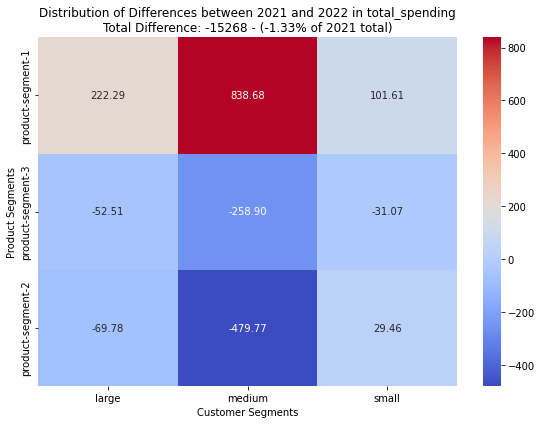

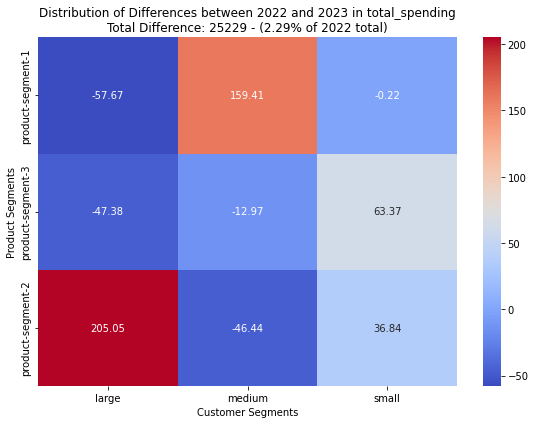

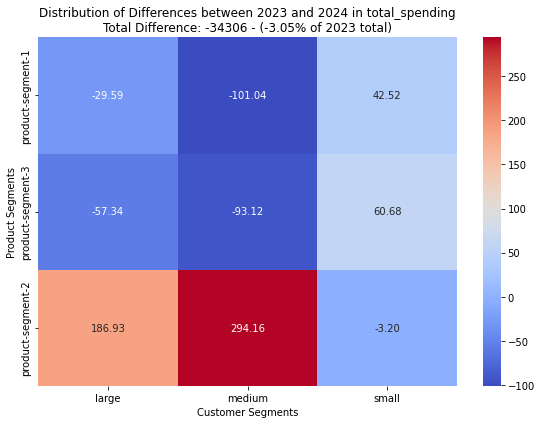

In [184]:
plot_heatmaps_for_year_pairs_perc(returning_customers_dfs, product_segments, user_segments, years, target)